In [10]:
import numpy as np
import math
import sys
from scipy.integrate import quad
from scipy.optimize import curve_fit
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.table import QTable
from astropy.table import Table, join, vstack, hstack
from astropy.table import Column


# open and tabulate data for M52
M52 = fits.open('M52_Members.fits')
M52_tab = Table(M52[1].data)

Pleiades_Vmag = []
Pleiades_BV = []

f=open('Pleiades.txt', "r")
lines=f.readlines()


for i in lines:
    Pleiades_Vmag.append(i.split(  )[2])
    Pleiades_BV.append(i.split(  )[3])

f.close()

# define previously derived constants
cardelli = 3.1 
A_v=2.15
Pleiades_distance = 136.2 
delta_M_Pleiades = 5*np.log10(Pleiades_distance/10)




# convert arrays to float datatype
Vmag_array = np.array(Pleiades_Vmag).astype(np.float)
BV_array = np.array(Pleiades_BV).astype(np.float)

# cut from full M52 table 
M52_cut = M52_tab['Vmag', 'Verr', 'B-V']


In [11]:
# Cut outlier stars from M52 table
# By eye: -0.5 < B-V < 0.75


i = 0 
while i in range(len(M52_cut)-1):
    
    if M52_cut['B-V'][i] < 0.25:
        M52_cut.remove_row(i)
        i+=1
    else:
        i+=1
        continue
k = 0

while k in range(len(M52_cut)-1):
    if M52_cut['B-V'][k] > 1.20:
        M52_cut.remove_row(k)
        k+=1
    else:
        k+=1
        continue
        

In [12]:
#calculate extinction and colour excess and then shift cluster
B_V_excess = A_v/ cardelli 

V_shift = M52_cut['Vmag'] - A_v

B_V_shift = M52_cut['B-V'] - B_V_excess


#shift pleiades to account for their distance from earth 
Vmag_array -= delta_M_Pleiades 


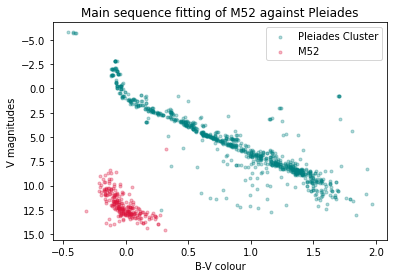

In [13]:
#plot positions of both main sequences
fig, ax = plt.subplots() 
ax.scatter(BV_array, Vmag_array, color = 'teal', label = 'Pleiades Cluster', s = 9, alpha = 0.3)
ax.scatter(B_V_shift, V_shift,  color = 'crimson', label = 'M52', s = 9, alpha =0.3 )
ax.invert_yaxis()
ax.set_ylabel('V magnitudes')
ax.set_xlabel('B-V colour')
ax.set_title('Main sequence fitting of M52 against Pleiades')

plt.legend()




In [14]:
#create mask to cut for interesting region to fit cluster
mask1 = ((B_V_shift > -0.05) & (B_V_shift < 0.2) & (V_shift > 9) & (V_shift < 13))
mask2 = ((BV_array > -0.05) & (BV_array < 0.2) & (Vmag_array > -3) & (Vmag_array < 6))

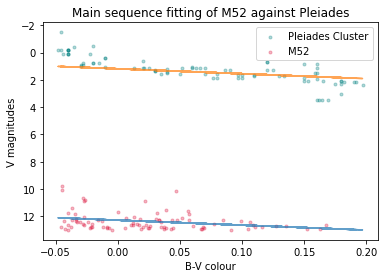

In [15]:
#create fitting function for determining chi-square
def func(x, a, b, c):
    return a*np.exp(-b*x) + c

#plot centre of cluster agaisnt pleiades and project fit line 
fig, ax = plt.subplots()
popt, pcov = curve_fit(func, B_V_shift[mask1], V_shift[mask1], maxfev = 5000)
k, q = curve_fit(func, B_V_shift[mask1], V_shift[mask1] -11.1, maxfev = 5000)
ax.plot(BV_array[mask2], func(BV_array[mask2], *popt), alpha = 0.7)
ax.plot(BV_array[mask2], func(BV_array[mask2], *k), alpha = 0.7)
ax.scatter(BV_array[mask2], Vmag_array[mask2], color = 'teal', label = 'Pleiades Cluster', s = 9, alpha = 0.3)
ax.scatter(B_V_shift[mask1], V_shift[mask1],  color = 'crimson', label = 'M52', s = 9, alpha =0.3 )
ax.invert_yaxis()
ax.set_ylabel('V magnitudes')
ax.set_xlabel('B-V colour')
ax.set_title('Main sequence fitting of M52 against Pleiades')
plt.legend()

In [16]:
#create arrays for appending data 
chisq_true = np.array([])

r_y_arr = np.ones(len(V_shift[mask1]))

#find distances between curve and cluster members
for k in range(len(V_shift[mask1])):
    ry = Vmag_array[mask2][k]  - func(B_V_shift[mask1][k], *popt)
    r_y_arr[k] *= ry

dist = np.arange(9.5, 13, 0.1)

#iterate through distance modulus values for chisquare minima
for val in dist:
    
    chisq_arr = np.ones(len(V_shift[mask1]))
    
    for q in range(len(V_shift[mask1])):
        chisq = ((r_y_arr[q]+val)**2)/(M52_cut['Verr'][q])**2 
            
        chisq_arr[q] *= chisq
      
    chisq_sum = np.sum(chisq_arr)
    
    chisq_true = np.append(chisq_true, chisq_sum)

#plot chi square
fig, ax = plt.subplots()


ax.scatter(dist, chisq_true, color = 'indigo', s=3)
ax.set_xlabel('m-M')
ax.set_ylabel('Chi-square')
ax.set_title('Finding a minimum of Chi-square (M52)')





IndexError: index 84 is out of bounds for axis 0 with size 84

In [ ]:
#print minimum value
result = np.where(chisq_true == np.min(chisq_true))
print(result)
print(dist[16])

In [17]:
#plot errors on minimum

one_sig = np.min(chisq_true) +1
fig, ax = plt.subplots()
ax.scatter(dist, chisq_true, color = 'green', s=2)
ax.set_xlabel('m-M')
ax.set_ylabel('Chi-square')
plt.axhline(y= one_sig)
ax.set_title('Finding a minimum of Chi-square')

ValueError: zero-size array to reduction operation minimum which has no identity